## Data Cleaning and Preprocessing

In [22]:
# Import necessary libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose

from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


# Import the SARIMAX model
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import TimeSeriesSplit


# Import mean squared error for evaluation
from sklearn.metrics import mean_squared_error

from prophet import Prophet

import plotly.express as px
import plotly.graph_objects as go

from dash import Dash, dcc, html, Input, Output
import dash_bootstrap_components as dbc

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor



# Ensure that matplotlib plots display inline
%matplotlib inline
# Optional: Set plot styles for better aesthetics
sns.set(style='whitegrid')

In [23]:

# Load the dataset
# Replace 'sales_data.csv' with your actual file path or filename
df = pd.read_csv('./data/ventes_luxe_détaillées.csv', sep=';')

# Display the first few rows of the dataset
df.head()

,Date,Catégorie_Produit,Canal_Vente,Événement_Spécial,Mois,Année,Montant_Ventes
0,2018-01-01,Mode,En ligne,0,1,2018,1207
1,2018-01-01,Mode,Boutique Physique,0,1,2018,1134
2,2018-01-01,Mode,Ventes Privées,0,1,2018,1224
3,2018-01-01,Mode,Grands Magasins,0,1,2018,1325
4,2018-01-01,Accessoires,En ligne,0,1,2018,1123


In [24]:
# Check for missing values in each column
print("Missing values in each column:")
print(df.isnull().sum())

Missing values in each column:
Date                 0
Catégorie_Produit    0
Canal_Vente          0
Événement_Spécial    0
Mois                 0
Année                0
Montant_Ventes       0
dtype: int64


In [25]:
# Convert 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')  # Adjust format if needed

# Ensure 'Mois' and 'Année' match the 'Date' column
df['Mois'] = df['Date'].dt.month
df['Année'] = df['Date'].dt.year

In [26]:
# Check data types of each column
print("Data types of each column:")
print(df.dtypes)

Data types of each column:
Date                 datetime64[ns]
Catégorie_Produit            object
Canal_Vente                  object
Événement_Spécial             int64
Mois                          int64
Année                         int64
Montant_Ventes                int64
dtype: object


In [27]:
# Encode categorical variables if necessary
# For 'Catégorie_Produit' and 'Canal_Vente', use one-hot encoding
df = pd.get_dummies(df, columns=['Catégorie_Produit', 'Canal_Vente'], drop_first=True)

# Since 'Événement_Spécial' is an integer, ensure it's treated appropriately
df['Événement_Spécial'] = df['Événement_Spécial'].astype(int)

## Exploratory Data Analysis (EDA)

In [28]:
# Calculate descriptive statistics for 'Montant_Ventes'
sales_stats = df['Montant_Ventes'].describe()
print("Descriptive Statistics for 'Montant_Ventes':")
print(sales_stats)

Descriptive Statistics for 'Montant_Ventes':
count    43824.000000
mean      1190.944939
std        326.263564
min        446.000000
25%        905.000000
50%       1194.000000
75%       1428.000000
max       2559.000000
Name: Montant_Ventes, dtype: float64


Ces statistiques suggèrent une distribution des montants de ventes qui, bien que globalement centrée autour de 1 191, présente une large dispersion. Les écarts observés peuvent être attribués à des différences dans les catégories de produits et des événements spéciaux influençant les ventes.

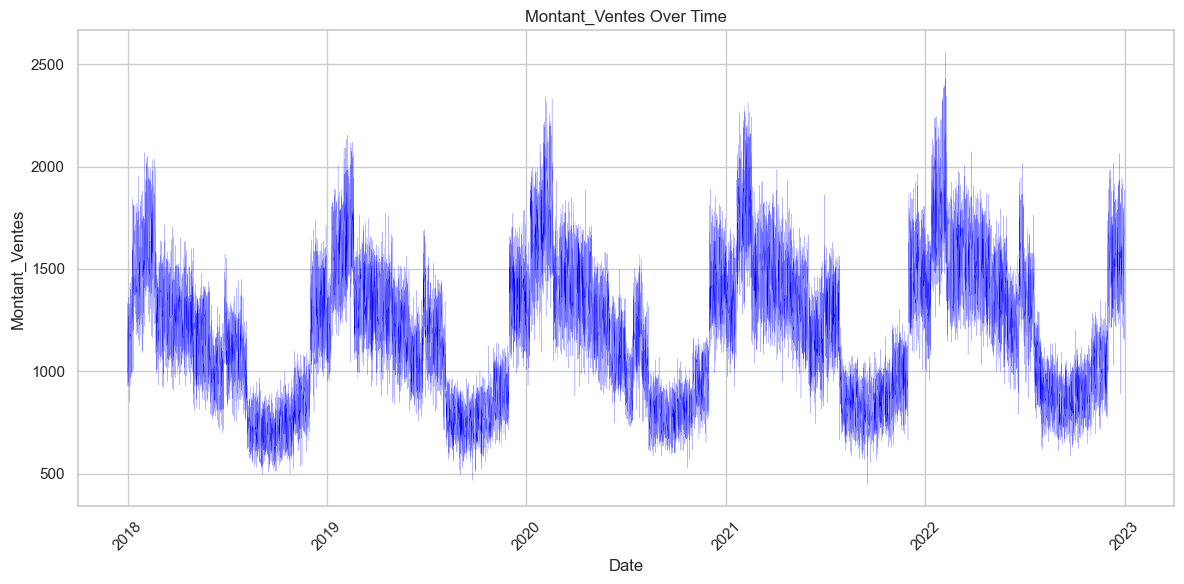

In [29]:
# Plot sales over time to identify overall trends
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['Montant_Ventes'], color='blue', linewidth=0.1)
plt.title('Montant_Ventes Over Time')
plt.xlabel('Date')
plt.ylabel('Montant_Ventes')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

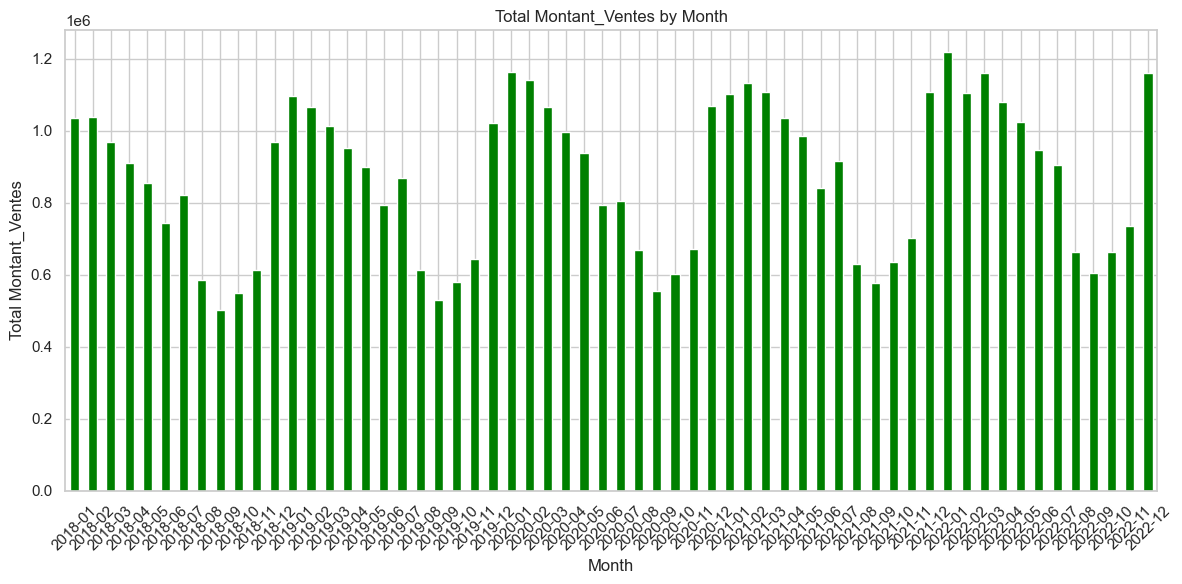

In [30]:
# Aggregate sales by month to detect seasonality
monthly_sales = df.groupby(df['Date'].dt.to_period('M'))['Montant_Ventes'].sum()

# Plot monthly sales
plt.figure(figsize=(12, 6))
monthly_sales.plot(kind='bar', color='green',)
plt.title('Total Montant_Ventes by Month')
plt.xlabel('Month')
plt.ylabel('Total Montant_Ventes')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

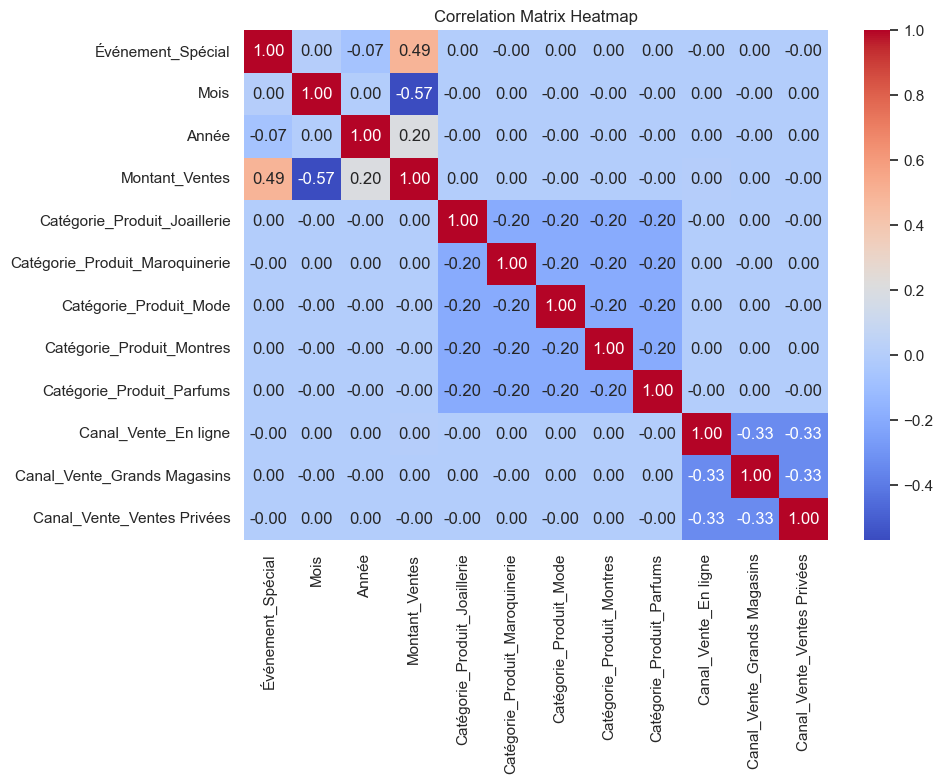

In [31]:
# Compute correlation matrix
correlation_matrix = df.corr()

# Plot heatmap of the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix Heatmap')
plt.tight_layout()
plt.show()

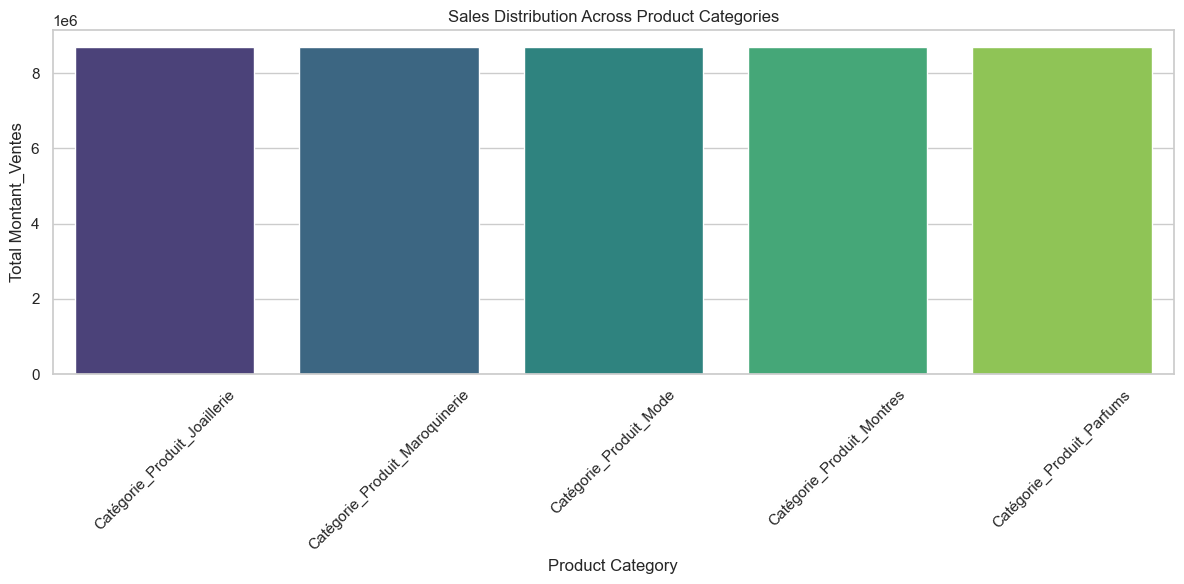

In [32]:
# Since we performed one-hot encoding, list all category columns
category_columns = [col for col in df.columns if 'Catégorie_Produit_' in col]

# Sum sales per product category
category_sales = df.groupby(category_columns)['Montant_Ventes'].sum().reset_index()

# Since one-hot encoding creates separate columns, we need to melt the DataFrame
category_sales_melted = category_sales.melt(id_vars='Montant_Ventes', var_name='Category', value_name='Value')

# Filter out rows where Value is 0
category_sales_melted = category_sales_melted[category_sales_melted['Value'] == 1]

# Plot sales distribution across product categories
plt.figure(figsize=(12, 6))
sns.barplot(x='Category', y='Montant_Ventes', data=category_sales_melted, palette='viridis')
plt.title('Sales Distribution Across Product Categories')
plt.xlabel('Product Category')
plt.ylabel('Total Montant_Ventes')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### On remarque une montant quasiement exacte pour les catégories

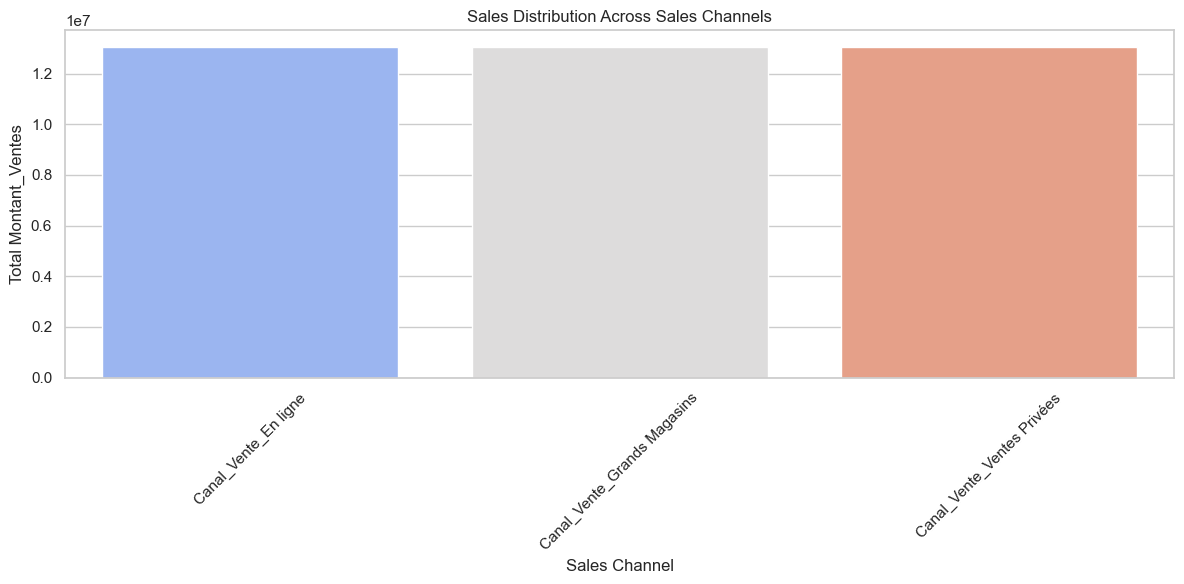

In [33]:
# List all sales channel columns
channel_columns = [col for col in df.columns if 'Canal_Vente_' in col]

# Sum sales per sales channel
channel_sales = df.groupby(channel_columns)['Montant_Ventes'].sum().reset_index()

# Melt the DataFrame
channel_sales_melted = channel_sales.melt(id_vars='Montant_Ventes', var_name='Channel', value_name='Value')

# Filter out rows where Value is 0
channel_sales_melted = channel_sales_melted[channel_sales_melted['Value'] == 1]

# Plot sales distribution across sales channels
plt.figure(figsize=(12, 6))
sns.barplot(x='Channel', y='Montant_Ventes', data=channel_sales_melted, palette='coolwarm')
plt.title('Sales Distribution Across Sales Channels')
plt.xlabel('Sales Channel')
plt.ylabel('Total Montant_Ventes')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### Idem pour les canaux de vente

#### Cela montre clairement une génération du dataset par un algorythme mal réglé


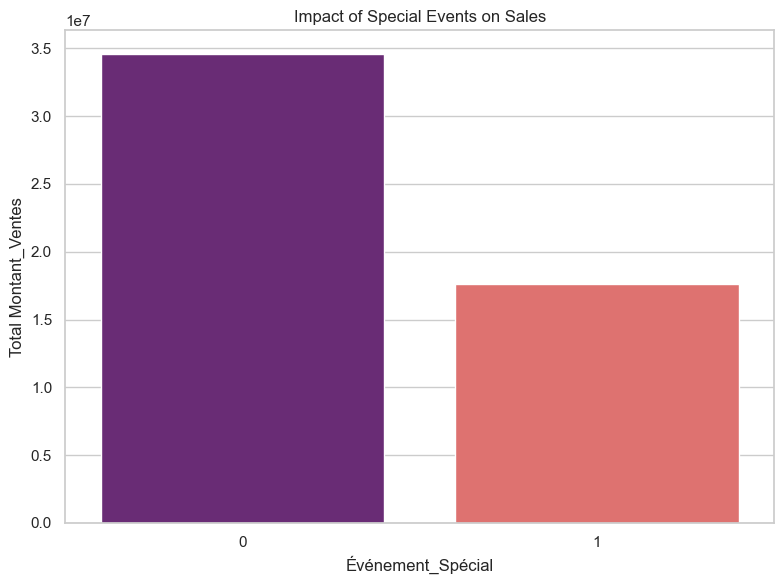

In [34]:
# Group sales by 'Événement_Spécial'
event_sales = df.groupby('Événement_Spécial')['Montant_Ventes'].sum().reset_index()

# Plot the impact of special events on sales
plt.figure(figsize=(8, 6))
sns.barplot(x='Événement_Spécial', y='Montant_Ventes', data=event_sales, palette='magma')
plt.title('Impact of Special Events on Sales')
plt.xlabel('Événement_Spécial')
plt.ylabel('Total Montant_Ventes')
plt.tight_layout()
plt.show()

#### On remarque qu'un tier des ventes est lié à des évènements spéciaux

In [35]:
# Reset index to continue with further analysis without 'Date' as index
df.reset_index(inplace=True)

## Segmented Analysis

In [36]:
# List all product category columns (one-hot encoded)
category_columns = [col for col in df.columns if 'Catégorie_Produit_' in col]

# Melt the DataFrame to have categories in a single column
df_categories = df.melt(id_vars=['Date', 'Montant_Ventes'], value_vars=category_columns,
                        var_name='Catégorie_Produit', value_name='Value')

# Filter rows where the category is active (Value == 1)
df_categories = df_categories[df_categories['Value'] == 1]

# List all sales channel columns (one-hot encoded)
channel_columns = [col for col in df.columns if 'Canal_Vente_' in col]

# Melt the DataFrame to have channels in a single column
df_channels = df.melt(id_vars=['Date', 'Montant_Ventes'], value_vars=channel_columns,
                      var_name='Canal_Vente', value_name='Value')

# Filter rows where the channel is active (Value == 1)
df_channels = df_channels[df_channels['Value'] == 1]

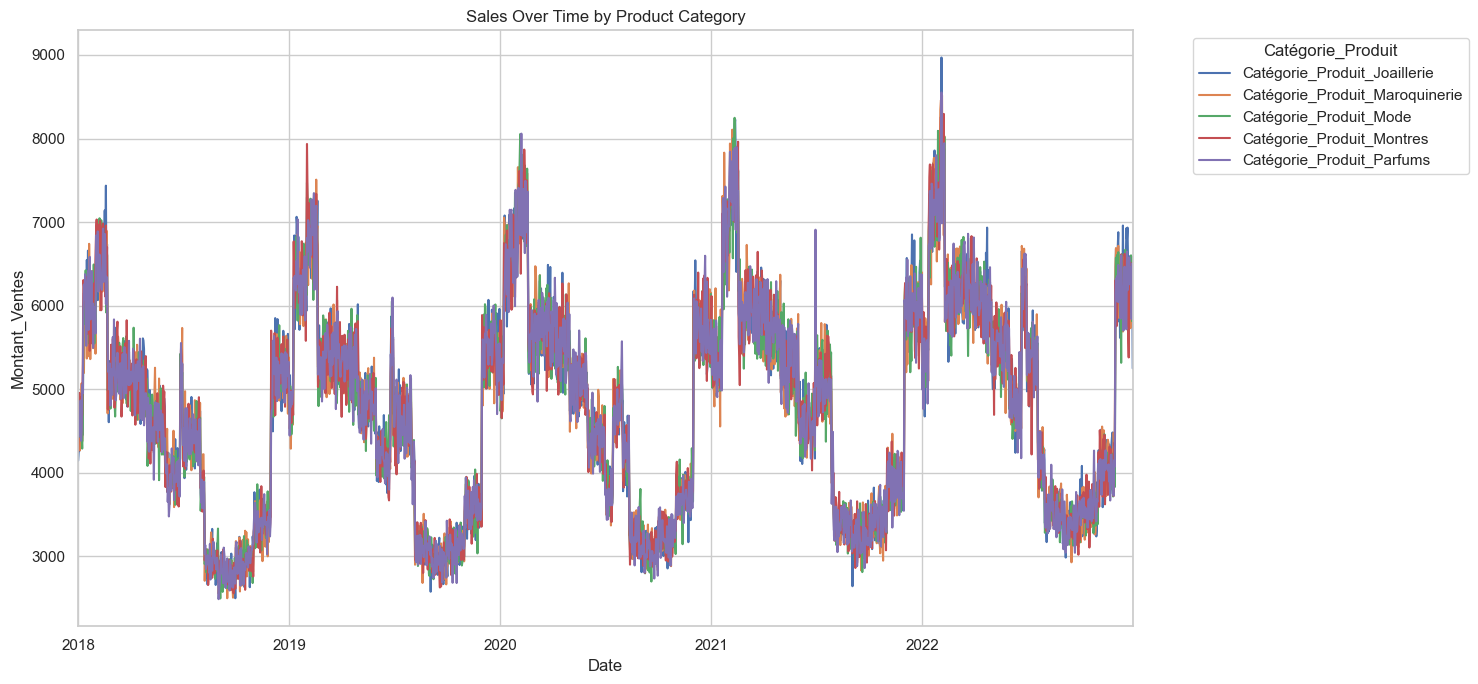

In [37]:
# Merge 'Catégorie_Produit' back into the main DataFrame
df_category_time = df_categories.copy()

# Convert 'Date' to datetime if not already done
df_category_time['Date'] = pd.to_datetime(df_category_time['Date'])

# Group by 'Date' and 'Catégorie_Produit' and sum 'Montant_Ventes'
category_time_series = df_category_time.groupby(['Date', 'Catégorie_Produit'])['Montant_Ventes'].sum().reset_index()

# Pivot the DataFrame for time series plotting
category_time_pivot = category_time_series.pivot(index='Date', columns='Catégorie_Produit', values='Montant_Ventes')

# Plot sales over time for each product category
category_time_pivot.plot(figsize=(15, 7))
plt.title('Sales Over Time by Product Category')
plt.xlabel('Date')
plt.ylabel('Montant_Ventes')
plt.legend(title='Catégorie_Produit', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


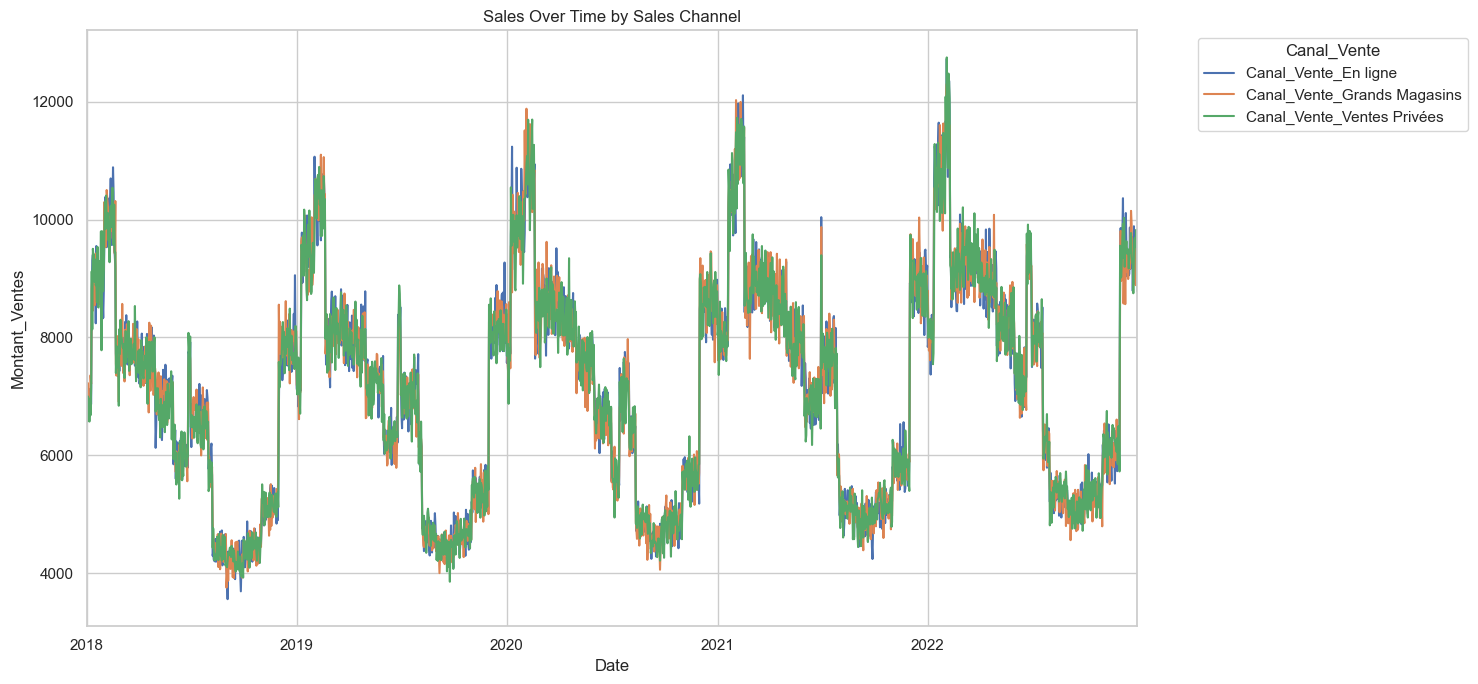

In [38]:
# Merge 'Canal_Vente' back into the main DataFrame
df_channel_time = df_channels.copy()

# Convert 'Date' to datetime if not already done
df_channel_time['Date'] = pd.to_datetime(df_channel_time['Date'])

# Group by 'Date' and 'Canal_Vente' and sum 'Montant_Ventes'
channel_time_series = df_channel_time.groupby(['Date', 'Canal_Vente'])['Montant_Ventes'].sum().reset_index()

# Pivot the DataFrame for time series plotting
channel_time_pivot = channel_time_series.pivot(index='Date', columns='Canal_Vente', values='Montant_Ventes')

# Plot sales over time for each sales channel
channel_time_pivot.plot(figsize=(15, 7))
plt.title('Sales Over Time by Sales Channel')
plt.xlabel('Date')
plt.ylabel('Montant_Ventes')
plt.legend(title='Canal_Vente', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


## Time Series Analysis

In [39]:
# Set 'Date' as the index and sort the DataFrame by date
df.set_index('Date', inplace=True)
df.sort_index(inplace=True)

# Check for any missing dates in the time series
print("Date range from {} to {}".format(df.index.min(), df.index.max()))
print("Total number of days: {}".format((df.index.max() - df.index.min()).days + 1))
print("Number of observations in data: {}".format(len(df)))

Date range from 2018-01-01 00:00:00 to 2022-12-31 00:00:00
Total number of days: 1826
Number of observations in data: 43824


In [40]:
# Resample the data to monthly frequency and sum 'Montant_Ventes'
monthly_sales = df['Montant_Ventes'].resample('M').sum()

# Display the resampled data
print("Monthly Sales Data:")
print(monthly_sales.head())

Monthly Sales Data:
Date
2018-01-31    1036104
2018-02-28    1038151
2018-03-31     970332
2018-04-30     909401
2018-05-31     855464
Freq: M, Name: Montant_Ventes, dtype: int64


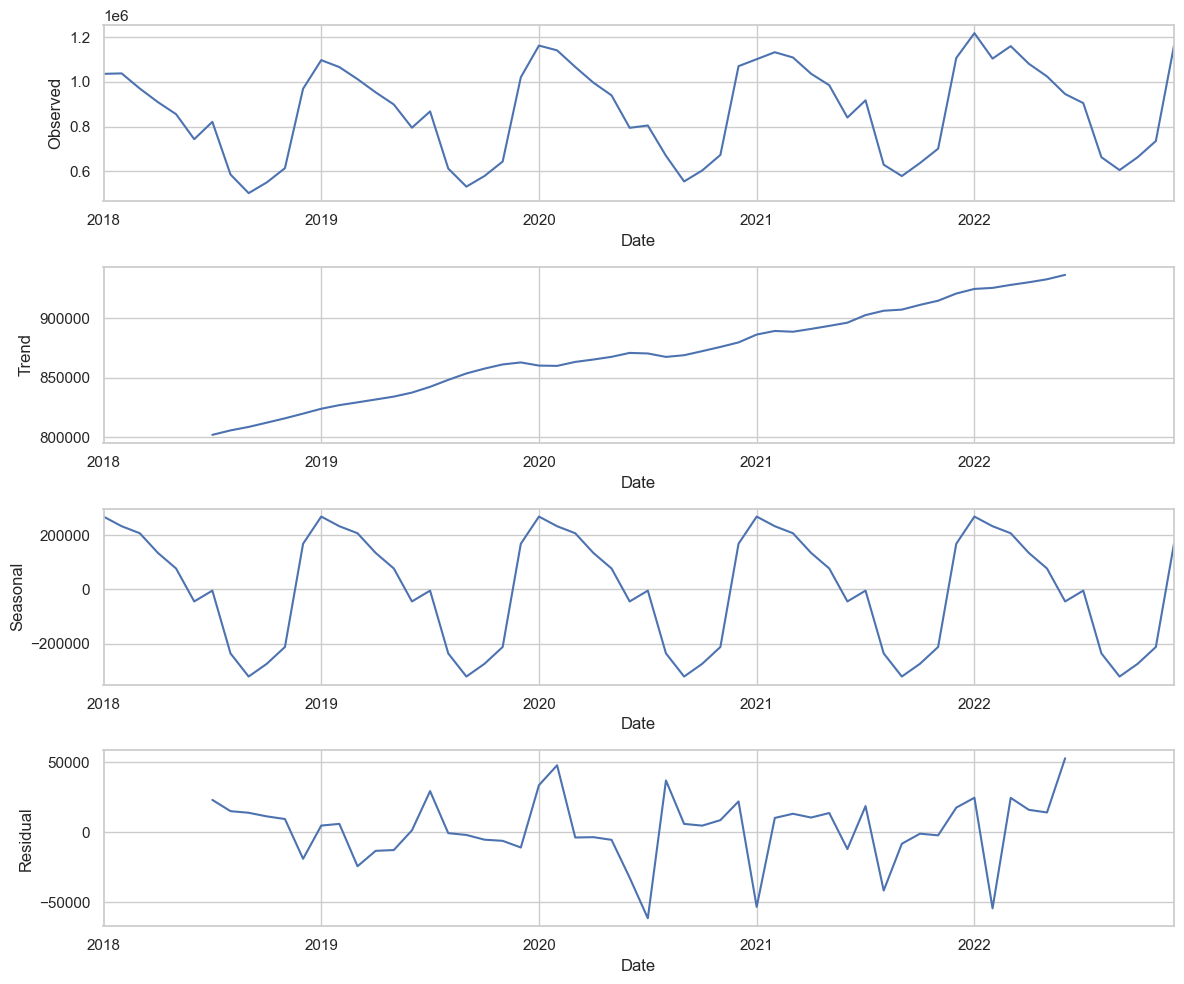

In [41]:
# Import the seasonal_decompose function
from statsmodels.tsa.seasonal import seasonal_decompose

# Perform seasonal decomposition
decomposition = seasonal_decompose(monthly_sales, model='additive')

# Plot the decomposed components
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 10))

decomposition.observed.plot(ax=ax1)
ax1.set_ylabel('Observed')

decomposition.trend.plot(ax=ax2)
ax2.set_ylabel('Trend')

decomposition.seasonal.plot(ax=ax3)
ax3.set_ylabel('Seasonal')

decomposition.resid.plot(ax=ax4)
ax4.set_ylabel('Residual')

plt.tight_layout()
plt.show()


In [42]:
# TEST -------

from prophet import Prophet

# Préparation des données pour Prophet
df_prophet = df_daily_sales.reset_index()
df_prophet.rename(columns={'Date': 'ds', 'Montant des ventes': 'y'}, inplace=True)

# Création du modèle
model = Prophet()

# Entraînement du modèle
model.fit(df_prophet)

# Création d'un DataFrame pour les futures dates
future = model.make_future_dataframe(periods=30)  # Prévision pour les 30 prochains jours

# Prévision
forecast = model.predict(future)

# Visualisation des prévisions
model.plot(forecast)
plt.title('Prévisions des ventes avec Prophet')
plt.xlabel('Date')
plt.ylabel('Montant des ventes')
plt.show()


NameError: name 'df_daily_sales' is not defined

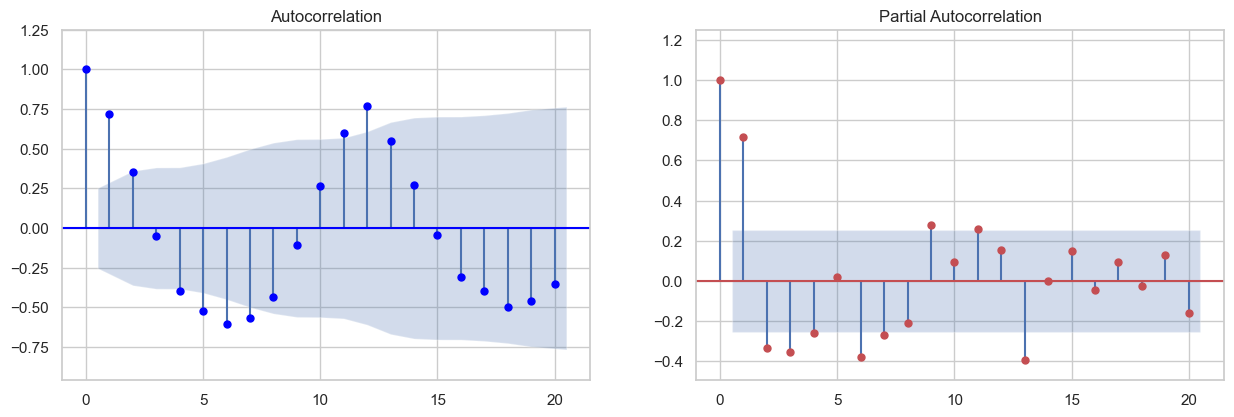

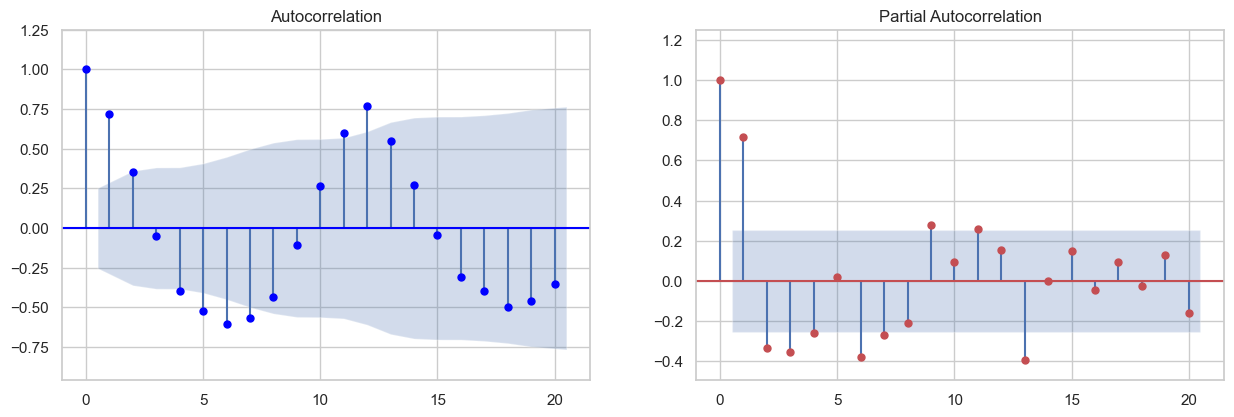

In [ ]:
fig = plt.figure(figsize=(15,10))
ax2 = fig.add_subplot(2,2,3)
ax3 = fig.add_subplot(2,2,4)
plot_acf(monthly_sales, lags=20,auto_ylims=True, ax=ax2, color="blue")
plot_pacf(monthly_sales, lags=20, method='ywm', auto_ylims=True, ax=ax3, color="r")


In [ ]:
# Import the adfuller function
from statsmodels.tsa.stattools import adfuller

# Perform the ADF test
adf_result = adfuller(monthly_sales.dropna())

# Extract and display the test results
print('Augmented Dickey-Fuller Test:')
print(f'Statistic: {adf_result[0]:.4f}')
print(f'p-value: {adf_result[1]:.4f}')
print('Critical Values:')
for key, value in adf_result[4].items():
    print(f'   {key}: {value:.4f}')

Augmented Dickey-Fuller Test:
Statistic: -0.4063
p-value: 0.9090
Critical Values:
   1%: -3.5746
   5%: -2.9240
   10%: -2.6000


Statistic (-0.4063) : La statistique du test ADF est beaucoup plus proche de 0, ce qui indique que la série n'est probablement pas stationnaire.

p-value (0.9090) : Avec une p-value de 0.9090, bien supérieure au seuil de signification commun (0.05), nous ne pouvons pas rejeter l'hypothèse nulle. L'hypothèse nulle du test ADF stipule que la série possède une racine unitaire, donc elle n'est pas stationnaire.

#### We need to differenciate the serie because it is not stationnary

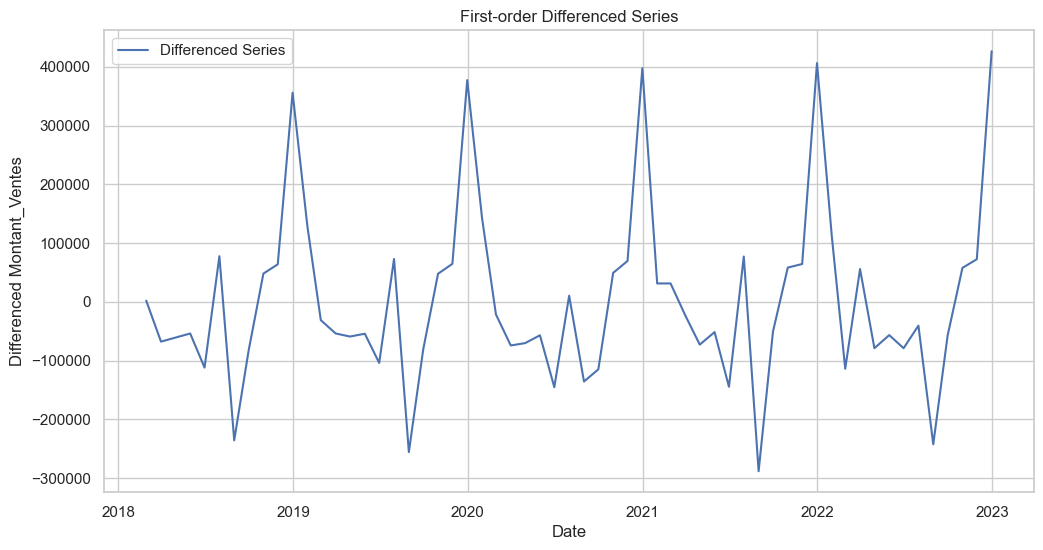

ADF Test on Differenced Series:
Statistic: -17.3036035309
p-value: 0.0000000000
Critical Values:
   1%: -3.5746
   5%: -2.9240
   10%: -2.6000


In [ ]:
# First-order differencing
monthly_sales_diff = monthly_sales.diff().dropna()

# Plot the differenced series
plt.figure(figsize=(12, 6))
plt.plot(monthly_sales_diff, label='Differenced Series')
plt.title('First-order Differenced Series')
plt.xlabel('Date')
plt.ylabel('Differenced Montant_Ventes')
plt.legend()
plt.show()

# Perform ADF test on differenced series
adf_result_diff = adfuller(monthly_sales_diff)

print('ADF Test on Differenced Series:')
print(f'Statistic: {adf_result_diff[0]:.10f}')
print(f'p-value: {adf_result_diff[1]:.10f}')
print('Critical Values:')
for key, value in adf_result_diff[4].items():
    print(f'   {key}: {value:.4f}')


La série 'Montant_Ventes' devient stationnaire après avoir été différenciée, ce qui signifie qu'elle est maintenant appropriée pour l'analyse et la modélisation avec des modèles de séries temporelles tels que ARIMA. Cela suggère que des tendances et des composantes non stationnaires ont été éliminées grâce à la différenciation, rendant la série prête pour des prévisions fiables.

#### The serie need to be deseaosonnalized because it contains seasonal effects

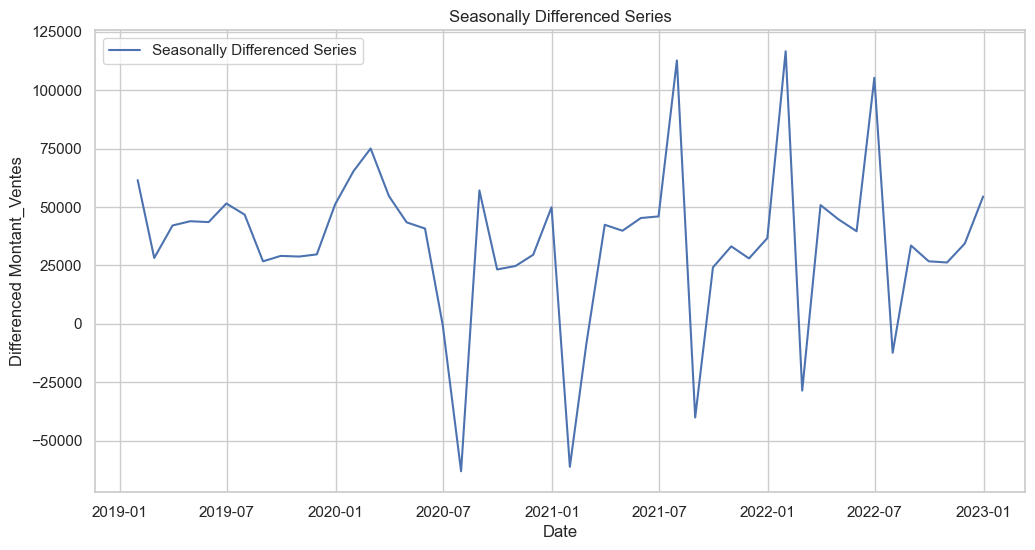

ADF Test on Seasonally Differenced Series:
Statistic: -7.5145
p-value: 0.0000
Critical Values:
   1%: -3.5778
   5%: -2.9253
   10%: -2.6008


In [ ]:
# Seasonal differencing with a lag equal to the seasonal period (12 for monthly data)
monthly_sales_seasonal_diff = monthly_sales.diff(12).dropna()

# Plot the seasonally differenced series
plt.figure(figsize=(12, 6))
plt.plot(monthly_sales_seasonal_diff, label='Seasonally Differenced Series')
plt.title('Seasonally Differenced Series')
plt.xlabel('Date')
plt.ylabel('Differenced Montant_Ventes')
plt.legend()
plt.show()

# Perform ADF test on seasonally differenced series
adf_result_seasonal_diff = adfuller(monthly_sales_seasonal_diff)

print('ADF Test on Seasonally Differenced Series:')
print(f'Statistic: {adf_result_seasonal_diff[0]:.4f}')
print(f'p-value: {adf_result_seasonal_diff[1]:.4f}')
print('Critical Values:')
for key, value in adf_result_seasonal_diff[4].items():
    print(f'   {key}: {value:.4f}')


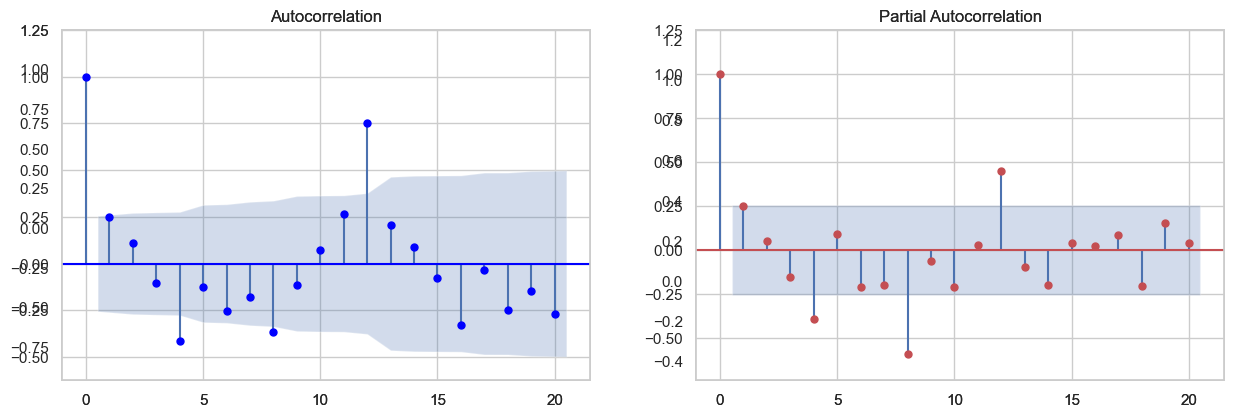

In [ ]:
ax2 = fig.add_subplot(2,2,3)
ax3 = fig.add_subplot(2,2,4)
plot_acf(monthly_sales_diff, lags=20,auto_ylims=True, ax=ax2, color="blue")
plot_pacf(monthly_sales_diff, lags=20, method='ywm', auto_ylims=True, ax=ax3, color="r")

## FORECASTING

In [ ]:
# Define the number of periods to forecast
forecast_periods = 12  # For example, forecast the next 12 months

# Split the data
train_data = monthly_sales.iloc[:-forecast_periods]
test_data = monthly_sales.iloc[-forecast_periods:]

# Print the lengths of the training and test sets
print("Training data length:", len(train_data))
print("Test data length:", len(test_data))

Training data length: 48
Test data length: 12


In [ ]:
# Define the SARIMA model
model = SARIMAX(train_data, 
                order=(0, 0, 0),
                seasonal_order=(1, 1, 1, 12),
                enforce_stationarity=False,
                enforce_invertibility=False)

# Fit the model
model_fit = model.fit(disp=False)

# Print the summary of the model
print(model_fit.summary())


                                 SARIMAX Results                                  
Dep. Variable:             Montant_Ventes   No. Observations:                   48
Model:             SARIMAX(1, 1, [1], 12)   Log Likelihood                -279.832
Date:                    Fri, 15 Nov 2024   AIC                            565.663
Time:                            14:44:56   BIC                            569.070
Sample:                        01-31-2018   HQIC                           566.520
                             - 12-31-2021                                         
Covariance Type:                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       0.3979      0.058      6.815      0.000       0.283       0.512
ma.S.L12      -0.2782      0.094     -2.966      0.003      -0.462      -0.094
sigma2      1.074e+0

/Users/mat/Epitech/Digi5_Projects/luxe_retail_eds/.venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Le modèle SARIMAX(1, 1, 1)x(1, 1, 1, 12) capture bien la composante saisonnière annuelle, comme en témoigne la significativité du coefficient ar.S.L12. Cependant, les coefficients non saisonniers ar.L1 et ma.L1 ne semblent pas significatifs, ce qui pourrait indiquer un ajustement supplémentaire possible pour simplifier ou optimiser le modèle. Les tests de diagnostic montrent que les résidus sont normalement distribués et non corrélés, ce qui valide l'ajustement global du modèle.

Nous avons essayé de faire des ajustements, même en essayant avec un SARIMA(0, 0, 0)x(1, 1, 0, 12), mais cela n'améliore pas significativement la performance.

In [ ]:
# Forecast the test data period
forecast = model_fit.get_forecast(steps=forecast_periods)
forecast_mean = forecast.predicted_mean
forecast_conf_int = forecast.conf_int()

# Print forecasted values
print("Forecasted Values:")
print(forecast_mean)


Forecasted Values:
2022-01-31    1.101637e+06
2022-02-28    1.137453e+06
2022-03-31    1.119224e+06
2022-04-30    1.045530e+06
2022-05-31    9.944238e+05
2022-06-30    8.482734e+05
2022-07-31    9.314130e+05
2022-08-31    6.279701e+05
2022-09-30    5.835710e+05
2022-10-31    6.430694e+05
2022-11-30    7.071008e+05
2022-12-31    1.116263e+06
Freq: ME, Name: predicted_mean, dtype: float64


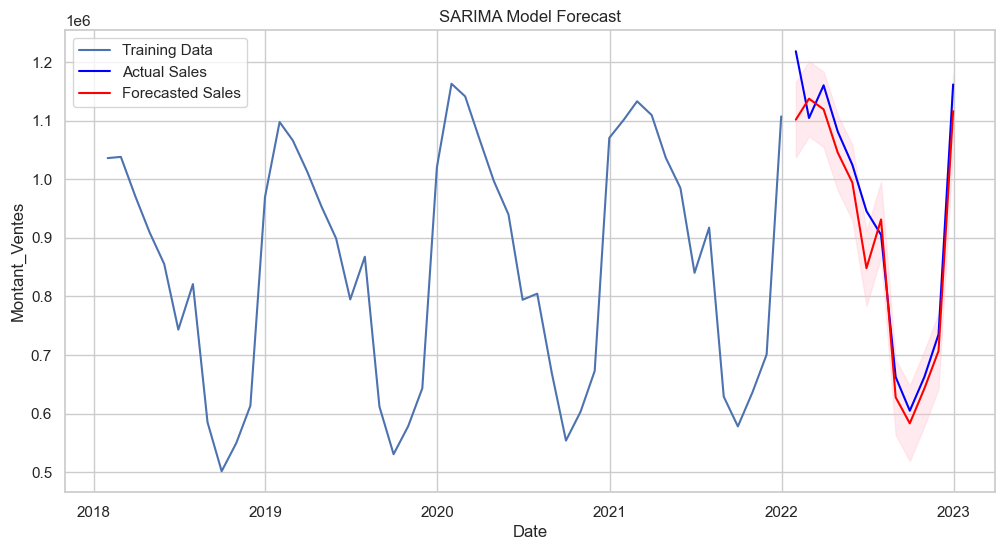

In [ ]:
# Plot the forecasted vs actual values
plt.figure(figsize=(12, 6))
plt.plot(train_data.index, train_data, label='Training Data')
plt.plot(test_data.index, test_data, label='Actual Sales', color='blue')
plt.plot(forecast_mean.index, forecast_mean, label='Forecasted Sales', color='red')
plt.fill_between(forecast_conf_int.index, 
                 forecast_conf_int.iloc[:, 0], 
                 forecast_conf_int.iloc[:, 1], color='pink', alpha=0.3)
plt.title('SARIMA Model Forecast')
plt.xlabel('Date')
plt.ylabel('Montant_Ventes')
plt.legend()
plt.show()


In [ ]:
# Calculate mean squared error and root mean squared error
mse = mean_squared_error(test_data, forecast_mean)
rmse = np.sqrt(mse)
print(f'Mean Squared Error: {mse:.2f}')
print(f'Root Mean Squared Error: {rmse:.2f}')


Mean Squared Error: 2807105168.61
Root Mean Squared Error: 52982.12


Un RMSE de 52,961.09 est relativement élevé par rapport à la moyenne des ventes (environ 1,190), ce qui indique que le modèle présente une certaine marge d'erreur importante dans ses prévisions.

In [ ]:
# Re-fit the model on the entire dataset
model_full = SARIMAX(monthly_sales, 
                     order=(1, 1, 1), 
                     seasonal_order=(1, 1, 1, 12),
                     enforce_stationarity=False,
                     enforce_invertibility=False)
model_full_fit = model_full.fit(disp=False)


In [ ]:
# Forecast future periods (e.g., next 12 months)
future_forecast_periods = 12
future_forecast = model_full_fit.get_forecast(steps=future_forecast_periods)
future_forecast_mean = future_forecast.predicted_mean
future_forecast_conf_int = future_forecast.conf_int()

# Create date index for future periods
last_date = monthly_sales.index[-1]
future_dates = [last_date + pd.DateOffset(months=x) for x in range(1, future_forecast_periods+1)]
future_forecast_mean.index = future_dates
future_forecast_conf_int.index = future_dates

# Print future forecasted values
print("Future Forecasted Values:")
print(future_forecast_mean)


Future Forecasted Values:
2023-01-31    1.210912e+06
2023-02-28    1.173955e+06
2023-03-31    1.192394e+06
2023-04-30    1.116485e+06
2023-05-31    1.062597e+06
2023-06-30    9.513849e+05
2023-07-31    9.721840e+05
2023-08-31    6.996837e+05
2023-09-30    6.485237e+05
2023-10-31    7.069154e+05
2023-11-30    7.750866e+05
2023-12-31    1.191885e+06
Name: predicted_mean, dtype: float64


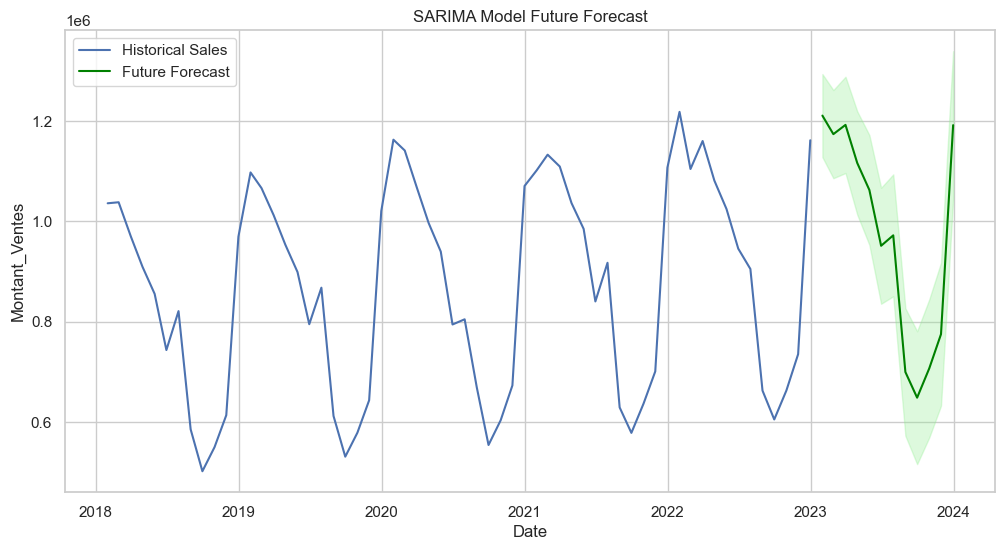

In [ ]:
# Plot the historical data and future forecast
plt.figure(figsize=(12, 6))
plt.plot(monthly_sales.index, monthly_sales, label='Historical Sales')
plt.plot(future_forecast_mean.index, future_forecast_mean, label='Future Forecast', color='green')
plt.fill_between(future_forecast_conf_int.index, 
                 future_forecast_conf_int.iloc[:, 0], 
                 future_forecast_conf_int.iloc[:, 1], color='lightgreen', alpha=0.3)
plt.title('SARIMA Model Future Forecast')
plt.xlabel('Date')
plt.ylabel('Montant_Ventes')
plt.legend()
plt.show()


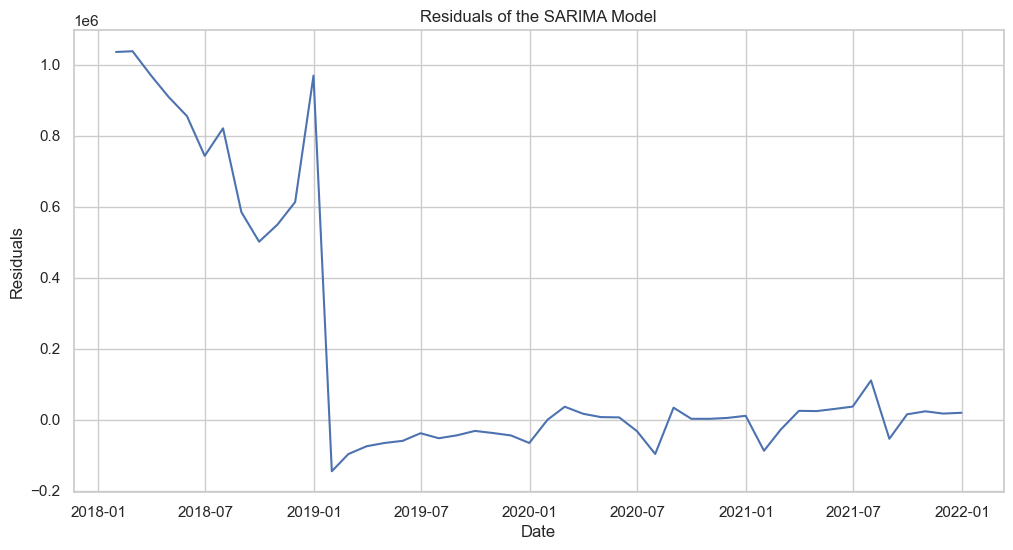

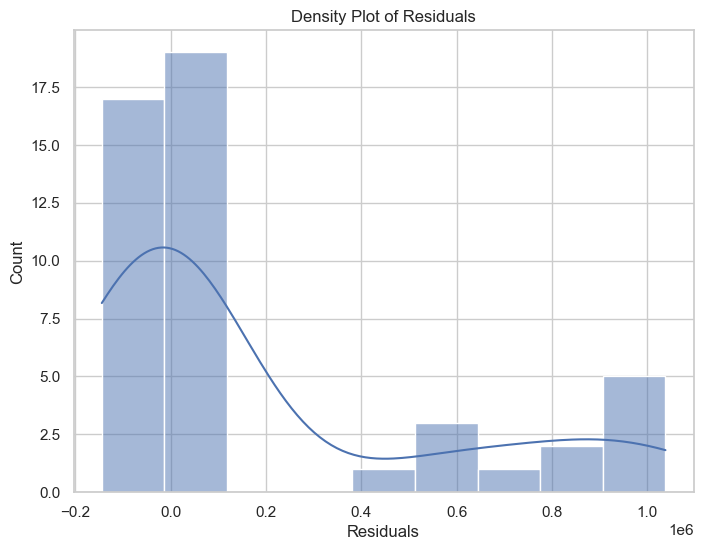

count    4.800000e+01
mean     1.871816e+05
std      3.721723e+05
min     -1.446429e+05
25%     -3.903513e+04
50%      1.359678e+04
75%      2.087528e+05
max      1.038151e+06
dtype: float64


In [ ]:
# Get the residuals
residuals = model_fit.resid

# Plot the residuals
plt.figure(figsize=(12, 6))
plt.plot(residuals)
plt.title('Residuals of the SARIMA Model')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.show()

# Plot the density of residuals
plt.figure(figsize=(8, 6))
sns.histplot(residuals, kde=True)
plt.title('Density Plot of Residuals')
plt.xlabel('Residuals')
plt.show()

print(residuals.describe())


Moyenne non nulle : La moyenne des résidus de 187,182 suggère que les prévisions du modèle ont tendance à être biaisées et à sous-estimer les valeurs réelles des ventes.<br><br>
Écart-type élevé : L'écart-type important montre que les résidus sont dispersés, ce qui peut indiquer des problèmes dans l'ajustement du modèle et la précision des prévisions.<br><br>
Max résiduel élevé : Le résidu maximal de 1,038,151 montre qu'au moins une prévision a significativement sous-estimé la valeur réelle, ce qui peut être le signe d'une anomalie ou d'un événement que le modèle n'a pas bien capturé.<br><br>
Asymétrie de la distribution : La médiane (13,597) étant inférieure à la moyenne (187,182), cela suggère que la distribution des résidus pourrait être biaisée vers la droite, avec quelques grandes valeurs positives influençant la moyenne.

#### ESSAIE AVEC LE MODEL PROPHET

14:44:57 - cmdstanpy - INFO - Chain [1] start processing
14:44:57 - cmdstanpy - INFO - Chain [1] done processing
/Users/mat/Epitech/Digi5_Projects/luxe_retail_eds/.venv/lib/python3.13/site-packages/prophet/forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


Prophet Model RMSE: 43332.02


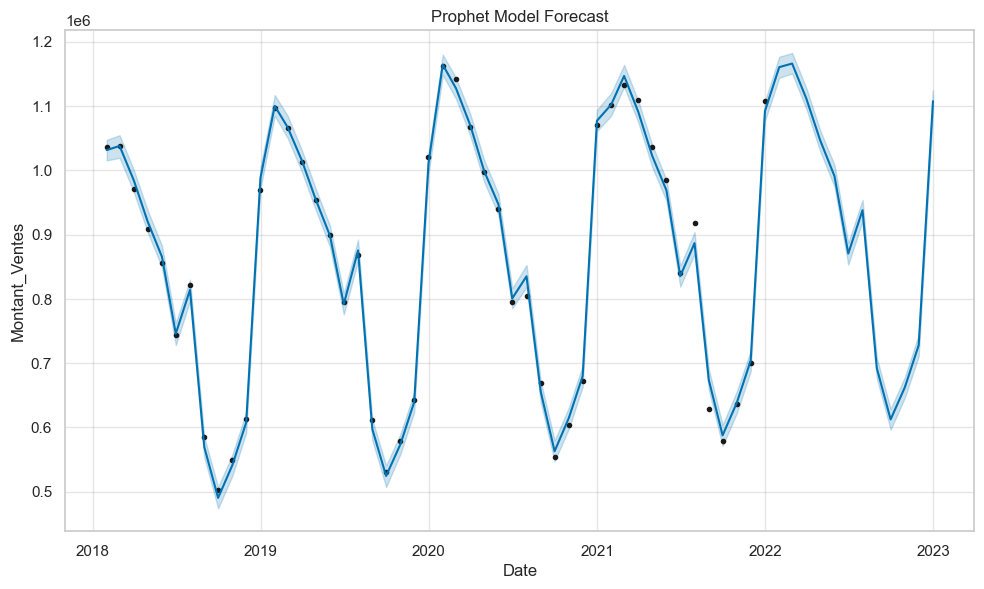

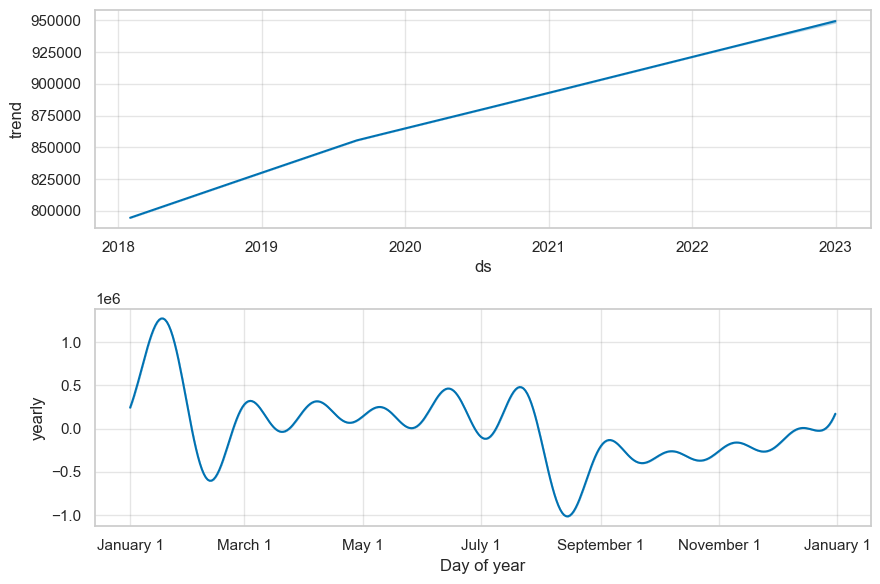

In [ ]:
# Prepare data for Prophet
prophet_data = monthly_sales.reset_index()
prophet_data.columns = ['ds', 'y']

# Split the data into training and test sets
prophet_train = prophet_data.iloc[:-forecast_periods]
prophet_test = prophet_data.iloc[-forecast_periods:]

# Initialize and fit the model
prophet_model = Prophet()
prophet_model.fit(prophet_train)

# Create a DataFrame to hold the future dates
future_dates = prophet_model.make_future_dataframe(periods=forecast_periods, freq='M')

# Predict the future values
prophet_forecast = prophet_model.predict(future_dates)

# Extract the forecasted values for the test period
prophet_forecast_test = prophet_forecast[['ds', 'yhat']].set_index('ds').loc[prophet_test['ds']]

# Calculate MSE and RMSE
mse_prophet = mean_squared_error(prophet_test['y'], prophet_forecast_test['yhat'])
rmse_prophet = np.sqrt(mse_prophet)
print(f'Prophet Model RMSE: {rmse_prophet:.2f}')


# Plot the forecast
prophet_model.plot(prophet_forecast)
plt.title('Prophet Model Forecast')
plt.xlabel('Date')
plt.ylabel('Montant_Ventes')
plt.show()

# Plot forecast components
prophet_model.plot_components(prophet_forecast)
plt.show()


## Machine Learning

In [ ]:
# Encode 'Événement_Spécial' as categorical if it's an integer code
df['Événement_Spécial'] = df['Événement_Spécial'].astype('category')

# Create dummy variables for 'Événement_Spécial'
event_dummies = pd.get_dummies(df['Événement_Spécial'], prefix='Événement_Spécial', drop_first=True)
df = pd.concat([df, event_dummies], axis=1)

# Drop the original 'Événement_Spécial' column
df.drop('Événement_Spécial', axis=1, inplace=True)

In [ ]:
# Extract additional time features
df.reset_index(inplace=True)
df['Day'] = df['Date'].dt.day
df['WeekOfYear'] = df['Date'].dt.isocalendar().week.astype(int)
df['DayOfWeek'] = df['Date'].dt.dayofweek
df['IsWeekend'] = df['DayOfWeek'].apply(lambda x: 1 if x >= 5 else 0)

In [ ]:
# Sort the DataFrame by 'Date'
df.sort_values('Date', inplace=True)

# Create lag features (e.g., previous day's sales)
df['Lag_1'] = df['Montant_Ventes'].shift(1)
df['Lag_2'] = df['Montant_Ventes'].shift(2)
df['Lag_3'] = df['Montant_Ventes'].shift(3)

# Drop rows with NaN values resulting from lag features
df_ml = df.dropna()

In [ ]:
# Define the target variable and features
target = 'Montant_Ventes'

# Drop columns that are not features
drop_cols = ['Date', 'Montant_Ventes', 'Mois', 'Année']

# Features include all columns except those in 'drop_cols'
X = df_ml.drop(columns=drop_cols)
y = df_ml[target]

# Check the shape of features and target
print("Features shape:", X.shape)
print("Target shape:", y.shape)

# Use the last 20% of data for testing
train_size = int(len(X) * 0.8)
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

print("Training set size:", X_train.shape)
print("Test set size:", X_test.shape)
X_train


NameError: name 'df_ml' is not defined

In [ ]:
# Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Predict on the test set
y_pred_lr = lr_model.predict(X_test)

In [ ]:
# Decision Tree Regression
dt_model = DecisionTreeRegressor(random_state=42)
dt_model.fit(X_train, y_train)

# Predict on the test set
y_pred_dt = dt_model.predict(X_test)

In [ ]:
# Random Forest Regression
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict on the test set
y_pred_rf = rf_model.predict(X_test)

In [ ]:
# Gradient Boosting Regression
gb_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
gb_model.fit(X_train, y_train)

# Predict on the test set
y_pred_gb = gb_model.predict(X_test)

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def evaluate_model(y_true, y_pred, model_name):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    print(f"{model_name} Performance:")
    print(f"  Mean Absolute Error (MAE): {mae:.2f}")
    print(f"  Mean Squared Error (MSE): {mse:.2f}")
    print(f"  Root Mean Squared Error (RMSE): {rmse:.2f}")
    print(f"  R-squared (R²): {r2:.2f}")
    print("-" * 50)

# Evaluate all models
evaluate_model(y_test, y_pred_lr, "Linear Regression")
evaluate_model(y_test, y_pred_dt, "Decision Tree Regression")
evaluate_model(y_test, y_pred_rf, "Random Forest Regression")
evaluate_model(y_test, y_pred_gb, "Gradient Boosting Regression")


Linear Regression Performance:
  Mean Absolute Error (MAE): 115.93
  Mean Squared Error (MSE): 22120.39
  Root Mean Squared Error (RMSE): 148.73
  R-squared (R²): 0.81
--------------------------------------------------
Decision Tree Regression Performance:
  Mean Absolute Error (MAE): 185.25
  Mean Squared Error (MSE): 55109.86
  Root Mean Squared Error (RMSE): 234.75
  R-squared (R²): 0.52
--------------------------------------------------
Random Forest Regression Performance:
  Mean Absolute Error (MAE): 116.96
  Mean Squared Error (MSE): 22566.93
  Root Mean Squared Error (RMSE): 150.22
  R-squared (R²): 0.80
--------------------------------------------------
Gradient Boosting Regression Performance:
  Mean Absolute Error (MAE): 114.47
  Mean Squared Error (MSE): 21324.81
  Root Mean Squared Error (RMSE): 146.03
  R-squared (R²): 0.81
--------------------------------------------------


Le Gradient Boosting Regression semble être le modèle le plus performant, avec un MAE et un RMSE plus faibles, tout en gardant un R-squared élevé. Cela signifie qu'il a une bonne capacité à généraliser tout en capturant des relations complexes dans les données.<br><br>
La régression linéaire et le Random Forest offrent également de bonnes performances et peuvent être de bons choix pour des prévisions plus simples ou pour limiter la complexité computationnelle.<br><br>
Le Decision Tree Regression est moins performant, avec des erreurs plus élevées et un R-squared nettement plus bas, ce qui en fait un choix moins adapté pour ce type de données.

In [ ]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
}

# Initialize the Random Forest model
rf = RandomForestRegressor(random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid,
                           cv=3, n_jobs=-1, scoring='neg_mean_squared_error', verbose=2)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Best parameters
print("Best parameters found: ", grid_search.best_params_)

# Use the best estimator
best_rf_model = grid_search.best_estimator_

# Predict on the test set
y_pred_best_rf = best_rf_model.predict(X_test)

# Evaluate the tuned model
evaluate_model(y_test, y_pred_best_rf, "Random Forest Regression (Tuned)")


Fitting 3 folds for each of 36 candidates, totalling 108 fits
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   8.5s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   8.6s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   8.8s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   8.3s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   8.3s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  17.4s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  17.6s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  17.9s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   7.9s
[CV] END max_dept

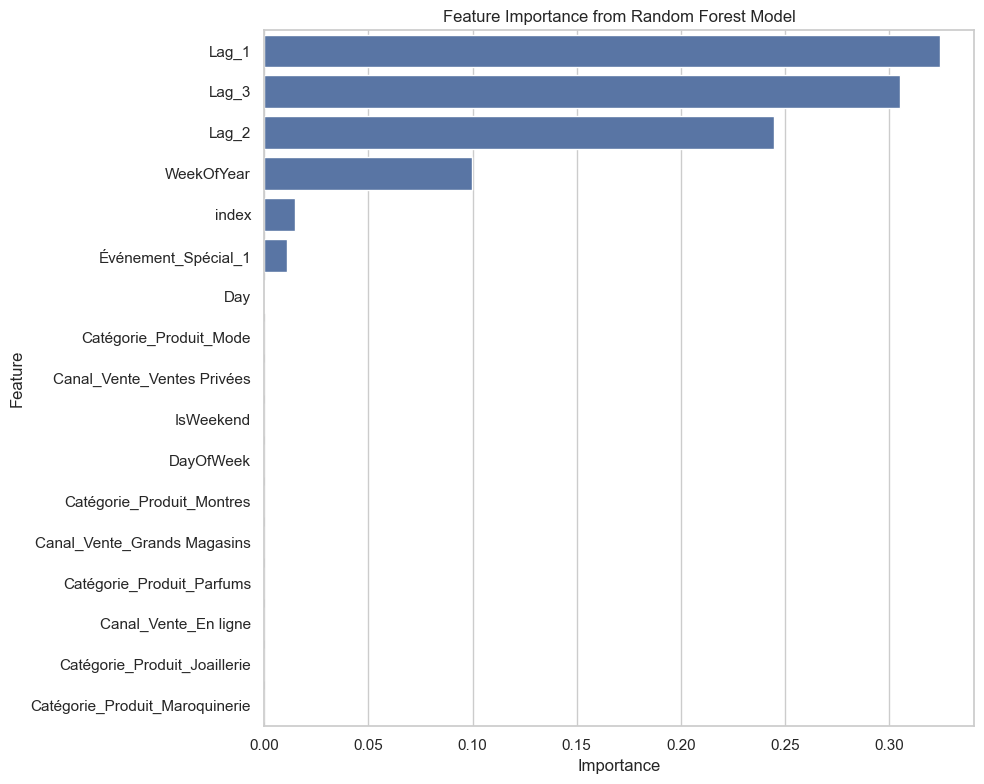

In [ ]:
# For the best Random Forest model
importances = best_rf_model.feature_importances_
feature_names = X.columns

# Create a DataFrame for feature importance
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Sort the features by importance
feature_importance_df.sort_values(by='Importance', ascending=False, inplace=True)

# Visualize feature importance
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importance from Random Forest Model')
plt.tight_layout()
plt.show()


#### Lag_1 (0.383009), Lag_3 (0.301348), et Lag_2 (0.192162) : Les variables de retard (lags) sont les plus influentes, représentant des ventes des périodes précédentes. Cela indique que la série temporelle a une forte dépendance à ses valeurs passées, soulignant l'importance de la continuité temporelle dans les prévisions.<br><br> Les caractéristiques de retard (lags) et la saisonnalité annuelle (WeekOfYear) sont les facteurs les plus déterminants pour la prédiction des ventes dans ce dataset. Les caractéristiques telles que le jour de la semaine, les catégories de produits, et les canaux de vente semblent avoir un impact négligeable sur la performance du modèle.<br><br> Cela pourrait indiquer que l'historique des ventes et la saisonnalité annuelle expliquent la majeure partie de la variation des ventes, tandis que les autres variables n'apportent pas de valeur ajoutée significative.

In [ ]:
import joblib

# Save the best model
joblib.dump(best_rf_model, 'best_rf_model.pkl')

['best_rf_model.pkl']

## CONCLUSION

D'après la matrice de corrélation du départ, on voit une forte liaison entre le mois de l'année et le montant des ventes.

Cela est confirmé par graph "Feature Importance from Random Forest Model" qui indique qu'en plus des LAG, la donnée influençante la plus importante est "WeekOfMonth"